In [ ]:
%cd /content/
!ls

/content
NAD57.mpg  sample_data


In [3]:
##DECOMPOSITION of video frames 14/03/2021
import sys
import shutil

import numpy as np
from math import floor
import pandas as pd
import numpy as np
import cv2

import os
import time
from PIL import Image
import math

# command line arguments --> file name, video_file_name, gpu or cpu 


# first decompose the video to frames
# place the video to be detected into the directory


#video = sys.argv[1]
#pred_text_file_name = sys.argv[2]

# resize image
#output = cv2.resize(src, dsize)


start = time.time()
text_file = 'frames.txt'

print('decomposing video to frames this may take a while  for large videos :) .....')
frames_path = 'video_frames/'
os.makedirs('video_frames/', exist_ok=True)
#os.makedirs('predictions/', exist_ok=True)

f = open(text_file, 'w+')
# Opens the Video file
cap= cv2.VideoCapture('/content/NAD57.mpg')
i=1
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == False:
        break
    scale_percent = 25

#calculate the 50 percent of original dimensions
    width = int(frame.shape[1] * scale_percent / 100)
    height = int(frame.shape[0] * scale_percent / 100)

# dsize
    dsize = (width, height)

    output = cv2.resize(frame, dsize) 
    frame_path = frames_path + 'frame_' + str(i) + '.jpg'
    cv2.imwrite("/content/video_frames/frame_"+ str(i) + ".jpg", output)
    f.write(frame_path + '\n')
    i+=1

cap.release()
cv2.destroyAllWindows()
print("decomposition complete")

end = time.time()
# total time taken
print(f"Runtime of the program is {end - start}")

decomposing video to frames this may take a while  for large videos :) .....
decomposition complete
Runtime of the program is 10.177934646606445


In [ ]:
#CIEDE2000 frame sequence difference 14/03/2021
import cv2
import numpy as np
from skimage import color
#from ciede2000 import CIEDE2000
import math

def CIEDE2000(Lab_1, Lab_2):
    '''Calculates CIEDE2000 color distance between two CIE L*a*b* colors'''
    C_25_7 = 6103515625 # 25**7
    
    L1, a1, b1 = Lab_1[0], Lab_1[1], Lab_1[2]
    L2, a2, b2 = Lab_2[0], Lab_2[1], Lab_2[2]
    C1 = math.sqrt(a1**2 + b1**2)
    C2 = math.sqrt(a2**2 + b2**2)
    C_ave = (C1 + C2) / 2
    G = 0.5 * (1 - math.sqrt(C_ave**7 / (C_ave**7 + C_25_7)))
    
    L1_, L2_ = L1, L2
    a1_, a2_ = (1 + G) * a1, (1 + G) * a2
    b1_, b2_ = b1, b2
    
    C1_ = math.sqrt(a1_**2 + b1_**2)
    C2_ = math.sqrt(a2_**2 + b2_**2)
    
    if b1_ == 0 and a1_ == 0: h1_ = 0
    elif a1_ >= 0: h1_ = math.atan2(b1_, a1_)
    else: h1_ = math.atan2(b1_, a1_) + 2 * math.pi
    
    if b2_ == 0 and a2_ == 0: h2_ = 0
    elif a2_ >= 0: h2_ = math.atan2(b2_, a2_)
    else: h2_ = math.atan2(b2_, a2_) + 2 * math.pi

    dL_ = L2_ - L1_
    dC_ = C2_ - C1_    
    dh_ = h2_ - h1_
    if C1_ * C2_ == 0: dh_ = 0
    elif dh_ > math.pi: dh_ -= 2 * math.pi
    elif dh_ < -math.pi: dh_ += 2 * math.pi        
    dH_ = 2 * math.sqrt(C1_ * C2_) * math.sin(dh_ / 2)
    
    L_ave = (L1_ + L2_) / 2
    C_ave = (C1_ + C2_) / 2
    
    _dh = abs(h1_ - h2_)
    _sh = h1_ + h2_
    C1C2 = C1_ * C2_
    
    if _dh <= math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2
    elif _dh  > math.pi and _sh < 2 * math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2 + math.pi
    elif _dh  > math.pi and _sh >= 2 * math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2 - math.pi 
    else: h_ave = h1_ + h2_
    
    T = 1 - 0.17 * math.cos(h_ave - math.pi / 6) + 0.24 * math.cos(2 * h_ave) + 0.32 * math.cos(3 * h_ave + math.pi / 30) - 0.2 * math.cos(4 * h_ave - 63 * math.pi / 180)
    
    h_ave_deg = h_ave * 180 / math.pi
    if h_ave_deg < 0: h_ave_deg += 360
    elif h_ave_deg > 360: h_ave_deg -= 360
    dTheta = 30 * math.exp(-(((h_ave_deg - 275) / 25)**2))
    
    R_C = 2 * math.sqrt(C_ave**7 / (C_ave**7 + C_25_7))  
    S_C = 1 + 0.045 * C_ave
    S_H = 1 + 0.015 * C_ave * T
    
    Lm50s = (L_ave - 50)**2
    S_L = 1 + 0.015 * Lm50s / math.sqrt(20 + Lm50s)
    R_T = -math.sin(dTheta * math.pi / 90) * R_C

    k_L, k_C, k_H = 1, 1, 1
    
    f_L = dL_ / k_L / S_L
    f_C = dC_ / k_C / S_C
    f_H = dH_ / k_H / S_H
    
    dE_00 = math.sqrt(f_L**2 + f_C**2 + f_H**2 + R_T * f_C * f_H)
    return dE_00


frame = []
labdiff = []
for k in range(1,12510):
  image1 = cv2.imread("/content/video_frames/frame_"+ str(k) + ".jpg")
  image2 = cv2.imread("/content/video_frames/frame_"+ str(k+1) + ".jpg")
  image1 = np.float32(image1)
  image1 *= 1./255
  image2 = np.float32(image2)
  image2 *= 1./255

  Lab1 = cv2.cvtColor(image1, cv2.COLOR_BGR2Lab)
  print(Lab1.shape)
  Lab2 = cv2.cvtColor(image2, cv2.COLOR_BGR2Lab)


  L1, a1, b1 = cv2.split(Lab1)
  L2, a2, b2 = cv2.split(Lab2)

#print(np.mean(L1))
#print(a1)
  diff = 0
  for i in range(0,Lab1.shape[0]):
    for j in range(0,Lab1.shape[1]):
      diff = diff + CIEDE2000((L1[i][j], a1[i][j], b1[i][j]), (L2[i][j], a2[i][j], b2[i][j]))
    #print(CIEDE2000((L1[i][j], a1[i][j], b1[i][j]), (L2[i][j], a2[i][j], b2[i][j])))
  print(k)
  print(k+1)
  print(diff/(60*88*3))
  frame.append(k)
  labdiff.append(diff/(60*88*3))
#print(CIEDE2000((50, 2.6772, -79.7751), (50, 0.0000, -82.7485)))





Streaming output truncated to the last 5000 lines.
(60, 88, 3)
11260
11261
0.5161970276671879
(60, 88, 3)
11261
11262
0.9350328926250003
(60, 88, 3)
11262
11263
0.9242532418039462
(60, 88, 3)
11263
11264
0.9424240271749291
(60, 88, 3)
11264
11265
0.906844212302857
(60, 88, 3)
11265
11266
0.4215920131946736
(60, 88, 3)
11266
11267
0.9379462599012004
(60, 88, 3)
11267
11268
0.8849048473342432
(60, 88, 3)
11268
11269
0.8914241222080718
(60, 88, 3)
11269
11270
0.9244497170113657
(60, 88, 3)
11270
11271
0.4127104194859847
(60, 88, 3)
11271
11272
0.8586092068581449
(60, 88, 3)
11272
11273
0.9800135191841208
(60, 88, 3)
11273
11274
0.9188577388006833
(60, 88, 3)
11274
11275
0.9110478008773336
(60, 88, 3)
11275
11276
0.5007928365181765
(60, 88, 3)
11276
11277
0.8392103225734096
(60, 88, 3)
11277
11278
0.8377755448337345
(60, 88, 3)
11278
11279
0.8651903598648937
(60, 88, 3)
11279
11280
0.8352585715168698
(60, 88, 3)
11280
11281
0.43484217969822714
(60, 88, 3)
11281
11282
0.7731822764482879
(60

In [ ]:
print(labdiff)
print(max(labdiff))
np.savetxt('/content/labdiff_original.txt', labdiff, fmt='%s', delimiter=' ')

[0.7973700344804119, 0.6678028301571849, 0.7800954297853963, 0.7800781772896781, 0.5941973497139073, 0.6014040879639568, 0.6685625976435052, 0.5588103729288899, 0.5654481405372201, 0.609988471493852, 0.47968375129737717, 0.6461290880035582, 0.5971326795348534, 0.5014143680299703, 0.554809143429761, 0.5932077259865244, 0.4838105084861479, 0.472500857122115, 0.5350098438097356, 0.3872144917212039, 0.43073836917399166, 0.3991513403406167, 0.2810178137406685, 0.3040309504736184, 0.31610093732161243, 0.2607993099753258, 0.2826516652415342, 0.2996261221466141, 0.29570839596127263, 0.30643193613929903, 0.3018195781942748, 0.2836292296992279, 0.30331979083258487, 0.2680896745018364, 0.22861970272800175, 0.2577910176630602, 0.3020010646377999, 0.2630293065414237, 0.26752540580632417, 0.30666798808153334, 0.2743712656019064, 0.25856300361262785, 0.2775489531387424, 0.2793882071901978, 0.29463248043952434, 0.2842332673299613, 0.28664645432848945, 0.2923941047540111, 0.27963215879264586, 0.2230149

No handles with labels found to put in legend.


MAX
12.247014861062882
[0.0651073  0.0545278  0.06369678 ... 0.00248362 0.00236874 0.00270808]
0.24536468853428367
0.24969452558197947
0.21743047073540905


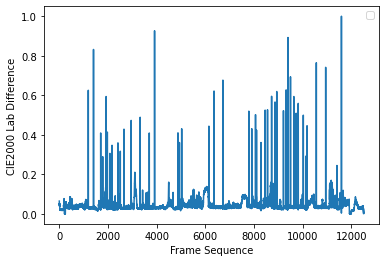

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

#plt.plot([0.1, 0.2, 0.3, 0.4], [1, 2, 3, 4])
#plt.plot([0.1, 0.2, 0.3, 0.4], [1, 4, 9, 16])
print("MAX")
print(max(labdiff))
frame = np.array(frame)
labdiff = np.array(labdiff)#*(240*352*3)
labdiff = labdiff/max(labdiff)
print(labdiff)
plt.plot(frame, (labdiff))#, label='CIEDE2000 Lab Difference')
plt.xlabel("Frame Sequence")
plt.ylabel("CIE2000 Lab Difference")
plt.legend()
#plt.savefig('labdiff.jpeg')
print(labdiff[11732]*3)
print(labdiff[11733]*3)
print(labdiff[11734]*3)



In [ ]:
#ABRUPT CUT
ab_cut = []
deli = 0.22
#labdiff = labdiff*max(labdiff)
for i in range(2,len(frame)):
  if(labdiff[i] > deli):
    if(labdiff[i-1] < deli):
      if(labdiff[i+1] < deli):
        ab_cut.append(i+139)

print(len(ab_cut))
print(ab_cut)
ab_cut = np.array(ab_cut)
np.savetxt('/content/ab_cut_22.txt', ab_cut, fmt='%s', delimiter=' ')

46
[1331, 1545, 1840, 1923, 2064, 2113, 2217, 2307, 2549, 2646, 2797, 3093, 3463, 3837, 4054, 5016, 5076, 5169, 6288, 6498, 6863, 7928, 8047, 8203, 8244, 8429, 8598, 8696, 8864, 9004, 9075, 9351, 9461, 9538, 9640, 9777, 9872, 9959, 10167, 10267, 10277, 10321, 10702, 11086, 11549, 11734]


In [4]:
#CIEDE2000 frame sequence difference 15/03/2021 GRADUAL TRANSITION
import cv2
import numpy as np
from skimage import color
#from ciede2000 import CIEDE2000
import math

frame = []
labdiff = []
sl = []
for k in range(1,12511):
  image1 = cv2.imread("/content/video_frames/frame_"+ str(k) + ".jpg")
  #image2 = cv2.imread("/content/video_frames/frame_"+ str(k+1) + ".jpg")
  image1 = np.float32(image1)
  image1 *= 1./255
  #image2 = np.float32(image2)
  #image2 *= 1./255

  Lab1 = cv2.cvtColor(image1, cv2.COLOR_BGR2Lab)
  #print(Lab1.shape)
  #Lab2 = cv2.cvtColor(image2, cv2.COLOR_BGR2Lab)


  L1, a1, b1 = cv2.split(Lab1)
  #L2, a2, b2 = cv2.split(Lab2)
  blur = cv2.blur(L1,(5,5))
  m1 = np.mean(blur)
  sl.append(m1)
  frame.append(k)

#print(np.mean(L1))
print(sl)
print(frame)
np.savetxt('/content/sl.txt', sl, fmt='%s', delimiter=' ')
np.savetxt('/content/fr_sl.txt', frame, fmt='%s', delimiter=' ')


[3.7955692, 5.084235, 6.247564, 7.6614156, 9.140785, 10.489057, 11.869367, 13.565696, 15.03411, 16.478874, 18.056122, 19.242376, 20.521275, 22.04817, 23.326109, 24.777046, 26.267555, 27.512726, 28.696236, 30.127415, 31.071728, 31.875095, 32.45849, 32.689915, 32.8983, 33.037926, 33.07921, 33.13296, 33.136173, 33.15222, 33.161243, 33.1578, 33.13876, 33.175156, 33.15951, 33.142, 33.091595, 33.08065, 33.04315, 33.05531, 33.029896, 33.05631, 33.062157, 33.125813, 33.05387, 33.068035, 33.010696, 33.0068, 33.03375, 33.063625, 33.043087, 33.078594, 33.062836, 33.036774, 33.066, 33.08544, 33.077972, 33.107983, 33.11245, 33.162933, 33.181305, 33.191597, 33.131184, 33.240307, 33.27319, 33.262035, 33.26293, 33.2731, 33.265858, 33.277878, 33.25225, 33.217068, 33.22036, 33.18927, 33.165657, 33.199207, 33.201538, 33.239582, 33.254936, 33.242714, 33.209953, 33.22801, 33.225117, 33.20067, 33.20279, 33.165787, 33.135853, 33.138283, 33.1285, 33.119343, 33.1521, 33.110092, 33.107773, 33.152622, 33.12327, 

In [39]:

#CIEDE2000 frame sequence difference 15/03/2021 GRADUAL TRANSITION psi matrix fillup
import cv2
import numpy as np
from skimage import color
#from ciede2000 import CIEDE2000
import math

frame = []
labdiff = []
sl = []
psi = []
for k in range(1,12510):
  image1 = cv2.imread("/content/video_frames/frame_"+ str(k) + ".jpg")
  image2 = cv2.imread("/content/video_frames/frame_"+ str(k+1) + ".jpg")
  image1 = np.float32(image1)
  image1 *= 1./255
  image2 = np.float32(image2)
  image2 *= 1./255

  Lab1 = cv2.cvtColor(image1, cv2.COLOR_BGR2Lab)
  #print(Lab1.shape)
  Lab2 = cv2.cvtColor(image2, cv2.COLOR_BGR2Lab)


  L1, a1, b1 = cv2.split(Lab1)
  L2, a2, b2 = cv2.split(Lab2)
  blur1 = cv2.blur(L1,(5,5))
  m1 = np.mean(blur1)
  blur2 = cv2.blur(L2,(5,5))
  m2 = np.mean(blur2)
  frame.append(k) 
  if ((m1-m2) >= 0):
    psi.append(1)
  else:
    psi.append(-1)
  
#print(np.mean(L1))
print(psi)
print(frame)

print(psi[317])
print(psi[318])

np.savetxt('/content/psi.txt', frame, fmt='%s', delimiter=' ')


[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, 1, 1, 1, 1, 1, -1, 1, -1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, -1, -1, -1, -1, 1, -1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, 1, -1, -1, -1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, -1, 1, -1, -1, 1, -1, 1, 1, 1, -1, 1, 1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, -1, 1, 1, 1, 1, 1, 1, -1, 1, -1, 1, 1, 1, -1, -1, -1, 1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, -1, 1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, 1, -1, 1, -1, 1, -1, 1, 1, 1, -1, 1, -1, 1, 1, 1, -1, 1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, 1, 

In [41]:
import numpy as np

sl = []
with open("/content/sl.txt", 'r') as fileobj:
    for row in fileobj:
      sl.append(row.rstrip('\n'))
        #print( row.rstrip('\n') )
print(sl)
sl = np.array(sl)
print(sl)

['3.7955692', '5.084235', '6.247564', '7.6614156', '9.140785', '10.489057', '11.869367', '13.565696', '15.03411', '16.478874', '18.056122', '19.242376', '20.521275', '22.04817', '23.326109', '24.777046', '26.267555', '27.512726', '28.696236', '30.127415', '31.071728', '31.875095', '32.45849', '32.689915', '32.8983', '33.037926', '33.07921', '33.13296', '33.136173', '33.15222', '33.161243', '33.1578', '33.13876', '33.175156', '33.15951', '33.142', '33.091595', '33.08065', '33.04315', '33.05531', '33.029896', '33.05631', '33.062157', '33.125813', '33.05387', '33.068035', '33.010696', '33.0068', '33.03375', '33.063625', '33.043087', '33.078594', '33.062836', '33.036774', '33.066', '33.08544', '33.077972', '33.107983', '33.11245', '33.162933', '33.181305', '33.191597', '33.131184', '33.240307', '33.27319', '33.262035', '33.26293', '33.2731', '33.265858', '33.277878', '33.25225', '33.217068', '33.22036', '33.18927', '33.165657', '33.199207', '33.201538', '33.239582', '33.254936', '33.242714

In [44]:
#FIRST PHASE OF GRADUAL TRANSITION 16/03/2021
import numpy as np

print(len(sl))
psi = []
frmpair = []
for k in range(0,12509):
  frmpair.append(k+1)
  d = np.float(sl[k]) - np.float(sl[k+1])
  if (d >= 0):
    psi.append(1)
  else:
    psi.append(-1)
#psi = np.array(psi)
np.savetxt('/content/psi.txt', psi, fmt='%s', delimiter=' ')
print(frmpair)
print(len(psi))
print(psi)

countp1 = 1
countm1 = 1
l = 0
t = 0
g = 2
phi = np.zeros(((len(psi)),(len(psi))))
for k in range(0,(len(psi)-1)):
  if (psi[k] == -1) and (psi[k+1] == -1):
    #if (psi[k] == -1):
    countm1 = countm1 + 1
    print("no of -1")
    print(countm1)
    if (countm1 > g):
      phi[l][t] = ((k+2))
      t = t + 1
    else:
      l = l + 1
  if (psi[k] == 1) and (psi[k+1] == 1):
    countp1 = countp1 + 1
    print("no of +1")
    print(countp1)
    if (countp1 > g):
      phi[l][t] = ((k+2))
      t = t + 1
    else:
      l = l + 1
  if (psi[k] == 1) and (psi[k+1] == -1):
    countp1 = 1
    countm1 = 1
    t = 0
    print(countp1)
    print(countm1)
  if (psi[k] == -1) and (psi[k+1] == 1):
    countp1 = 1
    countm1 = 1
    t = 0
    print(countp1)
    print(countm1)
v1 = []
v2 = []
for c in range(0,len(phi)):
  if(phi[c][0]!=0):
    v1.append(phi[c][0])
    
    v2.append(phi[c][0] + np.count_nonzero(phi[c][:]) - 1)

print(phi)
print((v1))
print((v2))
v1 = np.array(v1)
v2 = np.array(v2)
#np.savetxt('/content/v1.txt', v1, fmt='%s', delimiter=' ')
v12 = np.stack((v1, v2), axis = 1)
np.savetxt('/content/v12.txt', v12, fmt='%s', delimiter=' ')

Streaming output truncated to the last 5000 lines.
1
1
1
1
1
1
1
1
1
1
1
1
1
no of +1
2
no of +1
3
no of +1
4
no of +1
5
1
1
no of -1
2
no of -1
3
no of -1
4
1
1
no of +1
2
no of +1
3
no of +1
4
1
1
no of -1
2
no of -1
3
no of -1
4
no of -1
5
no of -1
6
no of -1
7
no of -1
8
no of -1
9
no of -1
10
no of -1
11
no of -1
12
no of -1
13
1
1
1
1
no of -1
2
1
1
1
1
no of -1
2
no of -1
3
no of -1
4
no of -1
5
1
1
1
1
no of -1
2
1
1
1
1
1
1
no of +1
2
1
1
no of -1
2
1
1
no of +1
2
no of +1
3
no of +1
4
no of +1
5
no of +1
6
no of +1
7
no of +1
8
no of +1
9
no of +1
10
1
1
no of -1
2
1
1
no of +1
2
no of +1
3
no of +1
4
no of +1
5
no of +1
6
no of +1
7
no of +1
8
1
1
no of -1
2
1
1
no of +1
2
1
1
no of -1
2
1
1
no of +1
2
no of +1
3
no of +1
4
1
1
1
1
no of +1
2
no of +1
3
no of +1
4
no of +1
5
no of +1
6
no of +1
7
no of +1
8
no of +1
9
1
1
no of -1
2
no of -1
3
no of -1
4
no of -1
5
no of -1
6
no of -1
7
no of -1
8
no of -1
9
no of -1
10
no of -1
11
no of -1
12
no of -1
13
no of -1
14
no of -

In [26]:
#CIEDE2000 frame sequence difference 14/03/2021 ORIGINAL PAPER
import cv2
import numpy as np
from skimage import color
#from ciede2000 import CIEDE2000
import math
import time
from matplotlib import pyplot as plt
import numpy as np

def CIEDE2000(Lab_1, Lab_2):
    '''Calculates CIEDE2000 color distance between two CIE L*a*b* colors'''
    C_25_7 = 6103515625 # 25**7
    
    L1, a1, b1 = Lab_1[0], Lab_1[1], Lab_1[2]
    L2, a2, b2 = Lab_2[0], Lab_2[1], Lab_2[2]
    C1 = math.sqrt(a1**2 + b1**2)
    C2 = math.sqrt(a2**2 + b2**2)
    C_ave = (C1 + C2) / 2
    G = 0.5 * (1 - math.sqrt(C_ave**7 / (C_ave**7 + C_25_7)))
    
    L1_, L2_ = L1, L2
    a1_, a2_ = (1 + G) * a1, (1 + G) * a2
    b1_, b2_ = b1, b2
    
    C1_ = math.sqrt(a1_**2 + b1_**2)
    C2_ = math.sqrt(a2_**2 + b2_**2)
    
    if b1_ == 0 and a1_ == 0: h1_ = 0
    elif a1_ >= 0: h1_ = math.atan2(b1_, a1_)
    else: h1_ = math.atan2(b1_, a1_) + 2 * math.pi
    
    if b2_ == 0 and a2_ == 0: h2_ = 0
    elif a2_ >= 0: h2_ = math.atan2(b2_, a2_)
    else: h2_ = math.atan2(b2_, a2_) + 2 * math.pi

    dL_ = L2_ - L1_
    dC_ = C2_ - C1_    
    dh_ = h2_ - h1_
    if C1_ * C2_ == 0: dh_ = 0
    elif dh_ > math.pi: dh_ -= 2 * math.pi
    elif dh_ < -math.pi: dh_ += 2 * math.pi        
    dH_ = 2 * math.sqrt(C1_ * C2_) * math.sin(dh_ / 2)
    
    L_ave = (L1_ + L2_) / 2
    C_ave = (C1_ + C2_) / 2
    
    _dh = abs(h1_ - h2_)
    _sh = h1_ + h2_
    C1C2 = C1_ * C2_
    
    if _dh <= math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2
    elif _dh  > math.pi and _sh < 2 * math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2 + math.pi
    elif _dh  > math.pi and _sh >= 2 * math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2 - math.pi 
    else: h_ave = h1_ + h2_
    
    T = 1 - 0.17 * math.cos(h_ave - math.pi / 6) + 0.24 * math.cos(2 * h_ave) + 0.32 * math.cos(3 * h_ave + math.pi / 30) - 0.2 * math.cos(4 * h_ave - 63 * math.pi / 180)
    
    h_ave_deg = h_ave * 180 / math.pi
    if h_ave_deg < 0: h_ave_deg += 360
    elif h_ave_deg > 360: h_ave_deg -= 360
    dTheta = 30 * math.exp(-(((h_ave_deg - 275) / 25)**2))
    
    R_C = 2 * math.sqrt(C_ave**7 / (C_ave**7 + C_25_7))  
    S_C = 1 + 0.045 * C_ave
    S_H = 1 + 0.015 * C_ave * T
    
    Lm50s = (L_ave - 50)**2
    S_L = 1 + 0.015 * Lm50s / math.sqrt(20 + Lm50s)
    R_T = -math.sin(dTheta * math.pi / 90) * R_C

    k_L, k_C, k_H = 1, 1, 1
    
    f_L = dL_ / k_L / S_L
    f_C = dC_ / k_C / S_C
    f_H = dH_ / k_H / S_H
    
    dE_00 = math.sqrt(f_L**2 + f_C**2 + f_H**2 + R_T * f_C * f_H)
    return dE_00
#start time
start = time.time()
frame = []
labdiff = []
for k in range(1,(len(v1)-1)):
  image1 = cv2.imread("/content/video_frames/frame_"+ str((np.int(v1[k])) - 5) + ".jpg")
  image2 = cv2.imread("/content/video_frames/frame_"+ str((np.int(v2[k])) +  5) + ".jpg")
  image1 = np.float32(image1)
  image1 *= 1./255
  image2 = np.float32(image2)
  image2 *= 1./255

  Lab1 = cv2.cvtColor(image1, cv2.COLOR_BGR2Lab)
  #print(Lab1.shape)
  Lab2 = cv2.cvtColor(image2, cv2.COLOR_BGR2Lab)


  L1, a1, b1 = cv2.split(Lab1)
  L2, a2, b2 = cv2.split(Lab2)

#print(np.mean(L1))
#print(a1)
  diff = 0
  for i in range(0,Lab1.shape[0]):
    for j in range(0,Lab1.shape[1]):
      diff = diff + CIEDE2000((L1[i][j], a1[i][j], b1[i][j]), (L2[i][j], a2[i][j], b2[i][j]))
    #print(CIEDE2000((L1[i][j], a1[i][j], b1[i][j]), (L2[i][j], a2[i][j], b2[i][j])))
  labdiff.append(diff/(60*88*3))

print(labdiff)
labdiff = np.array(labdiff)


KeyboardInterrupt: ignored

In [46]:
#CIEDE2000 frame sequence difference 14/03/2021 ORIGINAL PAPER with change from first gradual transition
import cv2
import numpy as np
from skimage import color
#from ciede2000 import CIEDE2000
import math
import time
from matplotlib import pyplot as plt
import numpy as np

def CIEDE2000(Lab_1, Lab_2):
    '''Calculates CIEDE2000 color distance between two CIE L*a*b* colors'''
    C_25_7 = 6103515625 # 25**7
    
    L1, a1, b1 = Lab_1[0], Lab_1[1], Lab_1[2]
    L2, a2, b2 = Lab_2[0], Lab_2[1], Lab_2[2]
    C1 = math.sqrt(a1**2 + b1**2)
    C2 = math.sqrt(a2**2 + b2**2)
    C_ave = (C1 + C2) / 2
    G = 0.5 * (1 - math.sqrt(C_ave**7 / (C_ave**7 + C_25_7)))
    
    L1_, L2_ = L1, L2
    a1_, a2_ = (1 + G) * a1, (1 + G) * a2
    b1_, b2_ = b1, b2
    
    C1_ = math.sqrt(a1_**2 + b1_**2)
    C2_ = math.sqrt(a2_**2 + b2_**2)
    
    if b1_ == 0 and a1_ == 0: h1_ = 0
    elif a1_ >= 0: h1_ = math.atan2(b1_, a1_)
    else: h1_ = math.atan2(b1_, a1_) + 2 * math.pi
    
    if b2_ == 0 and a2_ == 0: h2_ = 0
    elif a2_ >= 0: h2_ = math.atan2(b2_, a2_)
    else: h2_ = math.atan2(b2_, a2_) + 2 * math.pi

    dL_ = L2_ - L1_
    dC_ = C2_ - C1_    
    dh_ = h2_ - h1_
    if C1_ * C2_ == 0: dh_ = 0
    elif dh_ > math.pi: dh_ -= 2 * math.pi
    elif dh_ < -math.pi: dh_ += 2 * math.pi        
    dH_ = 2 * math.sqrt(C1_ * C2_) * math.sin(dh_ / 2)
    
    L_ave = (L1_ + L2_) / 2
    C_ave = (C1_ + C2_) / 2
    
    _dh = abs(h1_ - h2_)
    _sh = h1_ + h2_
    C1C2 = C1_ * C2_
    
    if _dh <= math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2
    elif _dh  > math.pi and _sh < 2 * math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2 + math.pi
    elif _dh  > math.pi and _sh >= 2 * math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2 - math.pi 
    else: h_ave = h1_ + h2_
    
    T = 1 - 0.17 * math.cos(h_ave - math.pi / 6) + 0.24 * math.cos(2 * h_ave) + 0.32 * math.cos(3 * h_ave + math.pi / 30) - 0.2 * math.cos(4 * h_ave - 63 * math.pi / 180)
    
    h_ave_deg = h_ave * 180 / math.pi
    if h_ave_deg < 0: h_ave_deg += 360
    elif h_ave_deg > 360: h_ave_deg -= 360
    dTheta = 30 * math.exp(-(((h_ave_deg - 275) / 25)**2))
    
    R_C = 2 * math.sqrt(C_ave**7 / (C_ave**7 + C_25_7))  
    S_C = 1 + 0.045 * C_ave
    S_H = 1 + 0.015 * C_ave * T
    
    Lm50s = (L_ave - 50)**2
    S_L = 1 + 0.015 * Lm50s / math.sqrt(20 + Lm50s)
    R_T = -math.sin(dTheta * math.pi / 90) * R_C

    k_L, k_C, k_H = 1, 1, 1
    
    f_L = dL_ / k_L / S_L
    f_C = dC_ / k_C / S_C
    f_H = dH_ / k_H / S_H
    
    dE_00 = math.sqrt(f_L**2 + f_C**2 + f_H**2 + R_T * f_C * f_H)
    return dE_00
#start time
start = time.time()
frame = []
labdiff = []
for k in range(0,(len(v1) - 1)):
  if (((np.int(v1[k])) - 5) == 0 or ((np.int(v1[k])) - 5) < 0):
    #image1 = cv2.imread("/content/video_frames/frame_"+ str((np.int(v1[k])) - 5) + ".jpg")
    image2 = cv2.imread("/content/video_frames/frame_"+ str((np.int(v2[k])) +  5) + ".jpg")
    #image1 = np.float32(image1)
    #image1 *= 1./255
    image2 = np.float32(image2)
    image2 *= 1./255

    #Lab1 = cv2.cvtColor(image1, cv2.COLOR_BGR2Lab)
  #print(Lab1.shape)
    Lab2 = cv2.cvtColor(image2, cv2.COLOR_BGR2Lab)


    #L1, a1, b1 = cv2.split(Lab1)
    L2, a2, b2 = cv2.split(Lab2)

#print(np.mean(L1))
#print(a1)
    diff = 0
    for i in range(0,Lab2.shape[0]):
      for j in range(0,Lab2.shape[1]):
        diff = diff + CIEDE2000((0, 0, 0), (L2[i][j], a2[i][j], b2[i][j]))
    #print(CIEDE2000((L1[i][j], a1[i][j], b1[i][j]), (L2[i][j], a2[i][j], b2[i][j])))
    labdiff.append(diff/(60*88*3))

  else:
    image1 = cv2.imread("/content/video_frames/frame_"+ str((np.int(v1[k])) - 5) + ".jpg")
    image2 = cv2.imread("/content/video_frames/frame_"+ str((np.int(v2[k])) +  5) + ".jpg")
    image1 = np.float32(image1)
    image1 *= 1./255
    image2 = np.float32(image2)
    image2 *= 1./255

    Lab1 = cv2.cvtColor(image1, cv2.COLOR_BGR2Lab)
  #print(Lab1.shape)
    Lab2 = cv2.cvtColor(image2, cv2.COLOR_BGR2Lab)


    L1, a1, b1 = cv2.split(Lab1)
    L2, a2, b2 = cv2.split(Lab2)

#print(np.mean(L1))
#print(a1)
    diff = 0
    for i in range(0,Lab1.shape[0]):
      for j in range(0,Lab1.shape[1]):
        diff = diff + CIEDE2000((L1[i][j], a1[i][j], b1[i][j]), (L2[i][j], a2[i][j], b2[i][j]))
    #print(CIEDE2000((L1[i][j], a1[i][j], b1[i][j]), (L2[i][j], a2[i][j], b2[i][j])))
    labdiff.append(diff/(60*88*3))

print(labdiff)
labdiff = np.array(labdiff)


[11.745818687438586, 0.375415217344959, 0.37545367963844595, 0.5067758425692696, 0.3808857147861632, 0.36303179688484005, 0.40408796963621835, 0.3975143016977497, 0.4282752783080484, 0.4974433913260591, 0.47314798697731675, 0.4453140864120166, 11.684218410439136, 0.07992315667262195, 0.01988005261766558, 0.0350496048069391, 0.048180515655001394, 11.486769718525094, 0.9309685165659011, 0.8993670049801392, 0.8765953088188934, 0.9173240115454669, 0.9237415393237554, 0.98793401936385, 0.9985809581849772, 1.268584518556099, 1.1787114844769746, 1.1006054622695272, 2.7658913652981894, 3.5527110011846608, 3.188554273152327, 3.7435996125143336, 3.485163557438197, 5.6761770612166496, 2.3979086527232796, 3.335940247322683, 2.690228493621293, 3.739727931811107, 3.058711364735316, 2.4496177433168946, 2.078375808136055, 2.000863554334773, 2.0798197247556893, 1.898366625895556, 1.7565367939054812, 8.67341702878913, 1.0666629538042776, 1.1096713031545233, 1.1127287170938496, 1.1701330960226952, 1.1547

In [47]:
#print(labdiff)
#labdiff = labdiff/12.247014861062882
#labdiff_grad = labdiff
#labdiff = labdiff_grad
print(max(labdiff))
#labdiff = labdiff*(60*80*3)
labdiff = labdiff/max(labdiff)
print(labdiff)
np.savetxt('/content/grad_labdiff.txt', labdiff, fmt='%s', delimiter=' ')

12.99882615599327
[0.90360611 0.0288807  0.02888366 ... 0.03861962 0.04112844 0.06387217]


In [48]:
#LAST VALIDATION OF GRADUAL CUT
st_fr = []
end_fr = []
for i in range(1,len(labdiff)):
  if(labdiff[i] > 0.03):
    st_fr.append(np.int(v1[i]))
    end_fr.append(np.int(v2[i]) )
print(st_fr)
print(end_fr)
len(st_fr)
st_fr = np.array(st_fr)
end_fr = np.array(end_fr)
featex = np.stack((st_fr, end_fr), axis = 1)
print(featex)
np.savetxt('/content/grad_cut_gt_pred.txt', featex, fmt='%s', delimiter=' ')
print(len(featex))


[59, 116, 124, 143, 150, 159, 162, 174, 251, 292, 299, 303, 314, 318, 325, 333, 339, 351, 361, 383, 421, 446, 451, 456, 459, 481, 484, 510, 515, 526, 531, 536, 541, 548, 559, 566, 572, 633, 636, 647, 650, 653, 657, 661, 671, 691, 700, 705, 726, 736, 740, 746, 761, 776, 780, 820, 840, 857, 866, 870, 874, 880, 889, 894, 903, 907, 918, 924, 935, 939, 948, 952, 974, 1010, 1014, 1021, 1025, 1038, 1046, 1050, 1056, 1061, 1066, 1110, 1113, 1116, 1131, 1146, 1158, 1169, 1173, 1178, 1194, 1202, 1214, 1221, 1226, 1232, 1250, 1258, 1264, 1268, 1274, 1279, 1287, 1290, 1296, 1328, 1344, 1349, 1353, 1360, 1366, 1373, 1377, 1384, 1389, 1397, 1402, 1411, 1414, 1419, 1427, 1432, 1440, 1446, 1456, 1461, 1467, 1473, 1477, 1484, 1491, 1496, 1501, 1506, 1540, 1570, 1576, 1580, 1590, 1595, 1603, 1640, 1644, 1650, 1659, 1664, 1667, 1680, 1687, 1694, 1927, 1939, 1945, 1949, 1966, 1974, 1984, 1990, 1995, 2008, 2021, 2037, 2046, 2055, 2062, 2066, 2069, 2073, 2077, 2086, 2094, 2098, 2101, 2115, 2122, 2135, 2138,

In [ ]:
r = range(1, 4)
1 in r
430/481

0.893970893970894

In [16]:
#EXTRACTING GROUNDTRUTH FROM XML FILE FOR ABRUPT CUT
import numpy as np
import xml.etree.ElementTree as ET
mytree = ET.parse('/content/ref_nad57.xml')
myroot = mytree.getroot()
print(int(myroot.attrib.get('totalFNum')))
totfno = int(myroot.attrib.get('totalFNum'))
prefno = []
postno = []
pref = []
postf = []
classi1 = []
cl = []
for x in myroot.findall('trans'):
  it1 = x.attrib.get('preFNum')

  it2 = x.attrib.get('postFNum')
  item =x.attrib.get('type')
  #print(item)
  prefno.append(int(it1))
  postno.append(int(it2))
  pref.append("frame%d.jpg" % int(it1))
  postf.append("frame%d.jpg" % int(it2))
  classi1.append(item)
  pre11 = []
  post11 = []
for i in range(len(classi1)):
  if (classi1[i]=='DIS' or classi1[i]=='FOI'):
    pre11.append(prefno[i])
    post11.append(postno[i])

#cl1 = np.array(cl)
pre1 = np.array(pre11)
post1 = np.array(post11)

feat1 = np.stack((pre1, post1), axis = 1)
print(feat1)
print(len(feat1))

np.savetxt('/content/gr_cut_gt.txt', feat1, fmt='%s', delimiter=' ')


12781
[[  317   417]
 [  710   764]
 [  914   984]
 [ 1199  1229]
 [ 1544  1545]
 [ 1741  1772]
 [ 4639  4654]
 [ 4802  4822]
 [ 5544  5570]
 [ 5766  5797]
 [ 5930  5963]
 [ 6023  6049]
 [ 7105  7137]
 [ 7271  7307]
 [ 7603  7651]
 [ 8523  8537]
 [10052 10077]
 [10940 10960]
 [11236 11255]
 [11468 11484]
 [11642 11661]
 [11782 11814]
 [12029 12195]]
23


In [49]:
#pre = 0
#RECALL CALCULATION
mat = np.zeros((len(feat1), len(featex)))
for i in range(0, len(featex)):
  a = featex[i][0]
  b = featex[i][1]
  for j in range(0, len(feat1)):
      r = range(feat1[j][0], feat1[j][1] + 1) 
      if((a in r) or (b in r)):
        mat[j][i] = 1

print(mat)
print(mat[0][8])
print(len(mat))
 
print(mat.sum(axis = 1))
pre_mat = mat.sum(axis = 1)
print(pre_mat)
print(pre_mat.shape)
print(pre_mat[0])
print(np.sum(pre_mat))

pre = 0
for i in range(0, len(pre_mat)):
  a = pre_mat[i]
  #print(a)
  if(a!= 0.0):
    pre = pre + 1

print("recall")
print(pre/len(pre_mat))

print(np.sum(pre_mat))

print(44/481)




#print(pre)


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
0.0
23
[7. 6. 7. 4. 0. 0. 3. 2. 5. 5. 2. 2. 5. 7. 5. 1. 2. 5. 3. 3. 2. 4. 4.]
[7. 6. 7. 4. 0. 0. 3. 2. 5. 5. 2. 2. 5. 7. 5. 1. 2. 5. 3. 3. 2. 4. 4.]
(23,)
7.0
84.0
recall
0.9130434782608695
84.0
0.09147609147609148


In [15]:
#PRECISION CALCULATION
mat1 = np.zeros((len(featex)))
for i in range(0, len(featex)):
  a = featex[i][0]
  b = featex[i][1]
  for j in range(0, len(feat1)):
      r = range(feat1[j][0], feat1[j][1] + 1) 
      if((a in r) or (b in r)):
        mat1[i] = 1
print(mat1)
print(len(mat1))

pred_mat = []

for i in range(0, (len(featex)-1)):
  #if((mat1[i] == 0.0) and (mat1[i+1] == 1.0)):
  #  pred_mat.append(0)
  if((mat1[i] == 1.0) and (mat1[i+1] == 0.0)):
    pred_mat.append(1)
print(len(pred_mat))
print("PRECISION")
print(len(pred_mat)/23)



[0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.
 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [ ]:
20*100/83.9

23.837902264600714

In [ ]:
#FORMATTED GRADUAL TRANSITION FOR PRECISION AND RECALL
print(feat1[0][0])

gt_form = []
for i in range(0,len(feat1)):
  for j in range(0, ((np.int(feat1[i][1])+ 1)-np.int(feat1[i][0]))):
    gt_form.append(np.int(feat1[i][0]) + j)

print(gt_form)
print(len(gt_form))

317
[317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 914, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938, 939, 940, 941, 942, 943, 944, 945, 946, 947, 948, 949, 950, 951, 952, 953, 954, 955, 956, 

In [ ]:
TP = 0
FN = 0
FP = 0

num = 0

for i in range(0, len(gt_form)):
  num = gt_form[i]
  if num in pred_frame:
    TP = TP + 1
  else:
    FN = FN + 1
print(TP)

TP = 0
for i in range(0,len(pred_frame)):
  num = pred_frame[i]
  if num in gt_form:
    TP = TP + 1
  else:
    FP = FP + 1

print(TP)

print("true positive")
print(TP)
print("false negative")
print(FN)
print("false positive")
print(FP)
Recall = TP/(TP + FN)

Precision = TP/(TP + FP)

F1 = 2*(Recall*Precision)/(Precision + Recall)
print("RECALL")
print(Recall)

print("PRECISION")
print(Precision)

print("F1 Score")
print(F1)





254
254
true positive
254
false negative
633
false positive
2388
RECALL
0.28635851183765504
PRECISION
0.09613928841786526
F1 Score
0.14395012751487676
